In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ucupsedaya_gojek_app_reviews_bahasa_indonesia_path = kagglehub.dataset_download('ucupsedaya/gojek-app-reviews-bahasa-indonesia')

print('Data source import complete.')


Data source import complete.


## Gojek Review Sentiment Analysis

### Problem Introduction

Even with a high rating of 4.7 and 4.4 on AppStore and PlayStore respectively. Gojek always strives to be a better man.. i meant app. It wants to know what worked and what didn't, so that Gojek can improve and make the world better with technology.

### Objective:

Create a model that is able to systematically classify positive and negative reviews. The model will classify reviews from all platforms and social media. This will lead to further action, such as gathering negative reviewers and performing a Focus Group Discusions (FGD).

### Contents of Notebook:
1. Basic EDA and Text Pre-processing
2. Traditional Machine Learning, Natural Language Processing by counting, Bag of Words (BoW).
3. Deep Learning Model, taking into account word order and meaning with Embedding.
4. Transfer Learning and Fine Tune Fill-Mask BERT Base Indonesian Model.

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, make_scorer, precision_score
from sklearn.metrics import roc_auc_score, f1_score

In [5]:
df = pd.read_csv('GojekAppReviewV4.0.0-V4.9.3_Cleaned.csv')

#Exploratory Data Analysis (EDA)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225002 entries, 0 to 225001
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   userName    225002 non-null  object
 1   content     225000 non-null  object
 2   score       225002 non-null  int64 
 3   at          225002 non-null  object
 4   appVersion  225002 non-null  object
dtypes: int64(1), object(4)
memory usage: 8.6+ MB


In [7]:
# removing name for privacy and to reduce any bias
df = df.drop(columns=['userName']);

In [8]:
df.head()

,content,score,at,appVersion
0,akun gopay saya di blok,1,2022-01-21 10:52:12,4.9.3
1,Lambat sekali sekarang ini bosssku apk gojek g...,3,2021-11-30 15:40:38,4.9.3
2,Kenapa sih dari kemarin sy buka aplikasi gojek...,4,2021-11-29 22:58:12,4.9.3
3,Baru download gojek dan hape baru trus ditop u...,1,2022-09-03 15:21:17,4.9.3
4,Mantap,5,2022-01-15 10:05:27,4.9.3


In [9]:
# removing neutral review
df = df[df['score'] != 3]

In [10]:
# Map 1-2 review into Negative, and 4-5 into Positive, not as good as manual human label.
target_map = {1: 'negative', 2: 'negative', 4: 'positive', 5: 'positive'}
df['target'] = df['score'].map(target_map)

# Map category into binar integer for model target
target_map = {'negative': 0, 'positive' : 1}
df['target_binary'] = df['target'].map(target_map)

<ipython-input-10-a7fefa787ace>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df['score'].map(target_map)
<ipython-input-10-a7fefa787ace>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target_binary'] = df['target'].map(target_map)


In [11]:
df.head()

,content,score,at,appVersion,target,target_binary
0,akun gopay saya di blok,1,2022-01-21 10:52:12,4.9.3,negative,0
2,Kenapa sih dari kemarin sy buka aplikasi gojek...,4,2021-11-29 22:58:12,4.9.3,positive,1
3,Baru download gojek dan hape baru trus ditop u...,1,2022-09-03 15:21:17,4.9.3,negative,0
4,Mantap,5,2022-01-15 10:05:27,4.9.3,positive,1
5,Bagus,4,2022-02-01 05:50:40,4.9.3,positive,1


In [12]:
# column name standardization
df.columns = ['text', 'score','date','app_version','target','target_binary']

In [13]:
df['app_version_cut'] = df['app_version'].str[:3]

<ipython-input-13-647617c12501>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['app_version_cut'] = df['app_version'].str[:3]


In [14]:
df.head()

,text,score,date,app_version,target,target_binary,app_version_cut
0,akun gopay saya di blok,1,2022-01-21 10:52:12,4.9.3,negative,0,4.9
2,Kenapa sih dari kemarin sy buka aplikasi gojek...,4,2021-11-29 22:58:12,4.9.3,positive,1,4.9
3,Baru download gojek dan hape baru trus ditop u...,1,2022-09-03 15:21:17,4.9.3,negative,0,4.9
4,Mantap,5,2022-01-15 10:05:27,4.9.3,positive,1,4.9
5,Bagus,4,2022-02-01 05:50:40,4.9.3,positive,1,4.9


<Axes: xlabel='target', ylabel='count'>

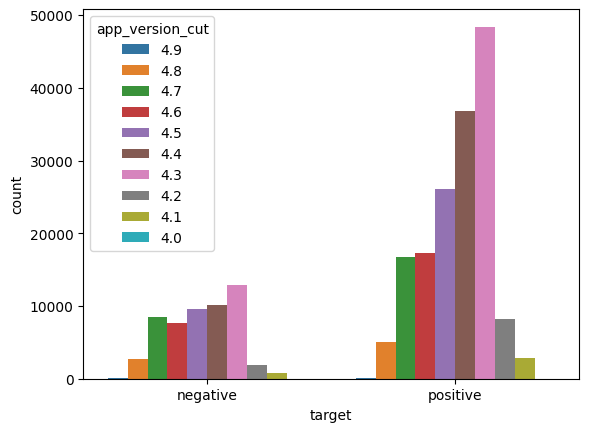

In [15]:
sns.countplot(data=df, x='target', hue='app_version_cut')

The positive and negative reviews looks evenly distributed. The positive reviews for version 4.3 is a bit higher compare to the rest.

In [16]:
df = df[df['app_version_cut'] >= '4.7']

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32969 entries, 0 to 34575
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             32969 non-null  object
 1   score            32969 non-null  int64 
 2   date             32969 non-null  object
 3   app_version      32969 non-null  object
 4   target           32969 non-null  object
 5   target_binary    32969 non-null  int64 
 6   app_version_cut  32969 non-null  object
dtypes: int64(2), object(5)
memory usage: 2.0+ MB


<Axes: xlabel='target', ylabel='count'>

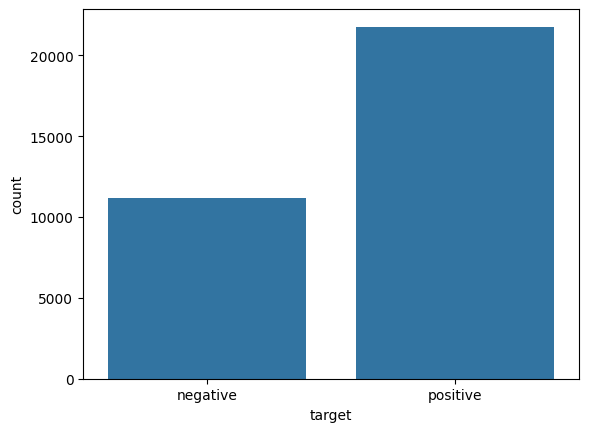

In [18]:
sns.countplot(data=df, x='target')

A little imbalanced, need to pay attetion on interpreting the model. No need for resampling.

# Text Preprocessing

In [19]:
pip install nlp_id

  Using cached huggingface_hub-0.23.4-py3-none-any.whl.metadata (12 kB)
Using cached huggingface_hub-0.23.4-py3-none-any.whl (402 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.27.0
    Uninstalling huggingface-hub-0.27.0:
      Successfully uninstalled huggingface-hub-0.27.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.14.0 requires huggingface-hub>=0.25.0, but you have huggingface-hub 0.23.4 which is incompatible.
transformers 4.47.1 requires huggingface-hub<1.0,>=0.24.0, but you have huggingface-hub 0.23.4 which is incompatible.


In [20]:
pip install indoNLP

In [21]:
import nltk
nltk.download
from nlp_id.lemmatizer import Lemmatizer
from indoNLP.preprocessing import replace_slang, replace_word_elongation

In [22]:
lemmatizer = Lemmatizer()
df['text_processed'] = df['text'].apply(lemmatizer.lemmatize)

In [23]:
# example
lemmatizer.lemmatize("menyusup lalu mengendap menyerupai bayangan")

'susup lalu endap rupa bayang'

In [24]:
df['text_processed'] = df['text_processed'].apply(replace_slang)

In [25]:
# example
replace_slang("emg siapa yg nanya?")

'memang siapa yang bertanya?'

In [26]:
df['text_processed'] = df['text_processed'].apply(replace_word_elongation)

In [27]:
# example
replace_word_elongation("kenapaaa?")

'kenapa?'

In [28]:
import nltk
nltk.download('stopwords')

# Download the punkt_tab data
nltk.download

def tokenize_text(text):
    # removing extra whitespaces "   halo  " into "halo"
    text = text.strip()
    tokens = nltk.word_tokenize(text)
    # removing any number and symbol tokens
    tokens = [token for token in tokens if token.isalpha()]
    return tokens

def remove_stopword(tokens):
    # removing common words such as "saya"
    stopwords = nltk.corpus.stopwords.words('indonesian')
    tokens = [token for token in tokens if token not in stopwords]
    return tokens

df['tokens'] = df['text_processed'].apply(tokenize_text)
df['tokens_without_stopword'] = df['tokens'].apply(remove_stopword)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
df['text_processed'] = df['tokens_without_stopword'].apply(" ".join)

In [30]:
df.head()

,text,score,date,app_version,target,target_binary,app_version_cut,text_processed,tokens,tokens_without_stopword
0,akun gopay saya di blok,1,2022-01-21 10:52:12,4.9.3,negative,0,4.9,akun gopay blok,"[akun, gopay, saya, di, blok]","[akun, gopay, blok]"
2,Kenapa sih dari kemarin sy buka aplikasi gojek...,4,2021-11-29 22:58:12,4.9.3,positive,1,4.9,sih kemarin buka aplikasi gojek kasih bintang ...,"[kenapa, sih, dari, kemarin, saya, buka, aplik...","[sih, kemarin, buka, aplikasi, gojek, kasih, b..."
3,Baru download gojek dan hape baru trus ditop u...,1,2022-09-03 15:21:17,4.9.3,negative,0,4.9,download gojek hape top lu gopay transaksi dia...,"[baru, download, gojek, dan, hape, baru, terus...","[download, gojek, hape, top, lu, gopay, transa..."
4,Mantap,5,2022-01-15 10:05:27,4.9.3,positive,1,4.9,mantap,[mantap],[mantap]
5,Bagus,4,2022-02-01 05:50:40,4.9.3,positive,1,4.9,bagus,[bagus],[bagus]


# Machine Learning, Natural Language Processing by counting, Bag of Words (BoW).

In [31]:
X = df['text_processed']
y = df['target_binary']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [33]:
# Transforming words into vector, only keep 3000 most common words
vectorizer = TfidfVectorizer(max_features=3000)

In [34]:
X_train = vectorizer.fit_transform(X_train)

In [35]:
X_test = vectorizer.transform(X_test)

In [36]:
X_test

<10880x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 47989 stored elements in Compressed Sparse Row format>

# **Logistic Regression**

In [37]:
log = LogisticRegression()
log.fit(X_train, y_train)
print("Model: Logistic Regression")
print("Train acc:", log.score(X_train, y_train))
print("Test acc:", log.score(X_test, y_test))

Model: Logistic Regression
Train acc: 0.9177418624654805
Test acc: 0.9050551470588235


Able to predict sentiments of 90% new data correctly. Even with slightly imbalance class, this result is good enough.

In [38]:
pr_train = log.predict_proba(X_train)[:, 1]
pr_test = log.predict_proba(X_test)[:, 1]
print("Train AUC:", roc_auc_score(y_train, pr_train))
print("Test AUC:", roc_auc_score(y_test, pr_test))

Train AUC: 0.9645175414386122
Test AUC: 0.9587032316413272


Across all thresholds, on average it able to differentiate the sentiment correctly 95.9%

In [39]:
def report(model):
    preds = model.predict(X_test)
    print(classification_report(y_test,preds,target_names=['negative','positive']))
    # Generate array of values for confusion matrix
    cm = confusion_matrix(y_test, preds, labels=model.classes_)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['negative','positive'])
    disp.plot();

              precision    recall  f1-score   support

    negative       0.86      0.86      0.86      3674
    positive       0.93      0.93      0.93      7206

    accuracy                           0.91     10880
   macro avg       0.89      0.89      0.89     10880
weighted avg       0.91      0.91      0.91     10880



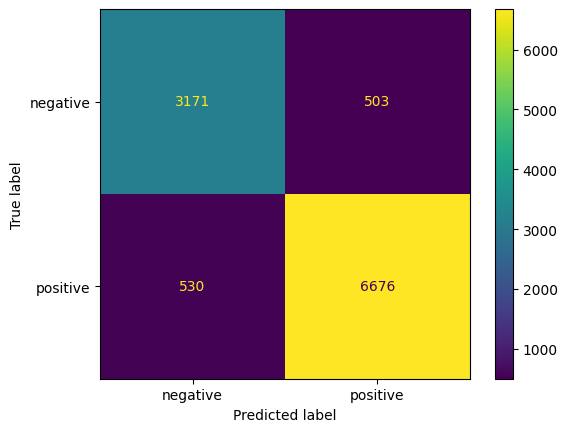

In [40]:
report(log)

Negative Prediction Interpretation

Precision: Out of all the data points the model classified as negative, how many were actually negative? <br> correctly predicted negative / all predicted negative (TP/TP+FP)<br>
3166 / (3166+526)

Recall: Out of all the actual negative data points, how many did the model correctly identify as negative?<br>
correctly predicted negative / all negative (TP/TP+FN)<br>
3166 / (3166+508)

While the negative class on overall has lower score than positive class, the model looks solid enough.

In [41]:
# weight for each vocabulary
log.coef_.shape

(1, 3000)

In [42]:
log.coef_

array([[-0.00282694, -0.58637725,  0.69377023, ...,  0.23613285,
        -0.73672264, -0.56893223]])

<Axes: ylabel='Count'>

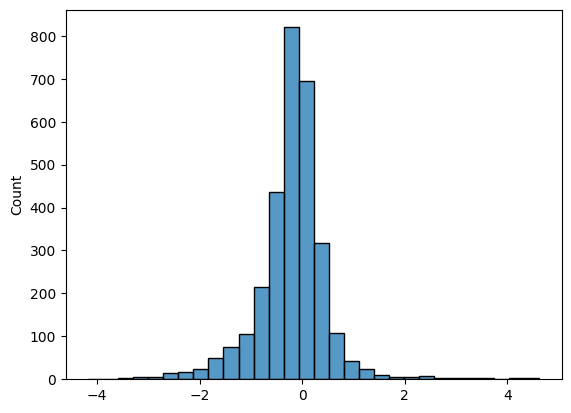

In [43]:
sns.histplot(log.coef_[0], bins=30)

Most of the words weight are around 0. The lower the weight is the more it makes the sentence negative and vice versa.

In [44]:
word_index_map = vectorizer.vocabulary_

In [45]:
word_index_map['gopay'] # {'gopay' : 2173}

934

In [46]:
threshold = 2.5
print("Most positive words:")
for word, index in word_index_map.items():
    weight = log.coef_[0][index]
    if weight > threshold:
        print(word, weight)

Most positive words:
cepat 3.1200113901534374
bagus 2.896270091851799
ok 3.6224405191628457
mudah 4.450038626445034
mantap 4.213988903361302
bantu 4.616784768511594
good 4.281535225251832
keren 3.6039004953354157
moga 2.818434778070674
oke 3.3115777172745693
terimakasih 2.8368256638052287
ramah 3.3475427518845717
nice 2.875349979253527
membanyaki 3.0241054002899332
mantul 2.6167473189076764


In [47]:
print("Most negative words:")
for word, index in word_index_map.items():
    weight = log.coef_[0][index]
    if weight < -threshold:
        print(word, weight)

Most negative words:
iklan -2.6412535017895307
payah -2.8519773151196333
buruk -3.549665878839633
parah -4.169882657985847
blokir -2.522856391791177
mahal -2.685252005683189
driver -2.5572103361593834
internet -2.5183415009863195
aneh -3.135358716735579
gopaylater -2.704828316341446
hilang -2.510521788074756
telat -3.321334890727066
error -2.5276053842303043
saldo -2.707659739323181
rugi -3.1250445010523022
up -2.610617722728786
jaring -3.1850641436526765
eror -3.05852678563918
paylater -2.956155583447813
tolol -2.8591195090052315
pelit -2.5910864825082807
lot -2.803454575439909
jelek -3.6346278570121626
lapor -2.70620588492432
mending -3.0693088310310452


For further use, need subject expert or more analysis to decide on how to classify the negative review. Clustering could be an option too.

In [48]:
X_full = vectorizer.transform(df['text_processed'])
probabilities = log.predict_proba(X_full)

In [49]:
predictions = log.predict(X_full)

In [50]:
df.shape

(32969, 10)

In [51]:
len(predictions)

32969

In [52]:
df['prediction'] = predictions
df['prediction'] = df['prediction'].map({0:'negative',1:'positive'})

In [53]:
probabilities

array([[0.79884232, 0.20115768],
       [0.54166779, 0.45833221],
       [0.36592868, 0.63407132],
       ...,
       [0.00825262, 0.99174738],
       [0.01764614, 0.98235386],
       [0.53530177, 0.46469823]])

In [54]:
df['prediction_confidence'] = probabilities[:,0]

In [55]:
def reverse_confidence(value):
    # if positive
    if value < 0.5:
        return 1-value
    else:
        return value

In [56]:
df['prediction_confidence'] = df['prediction_confidence'].apply(reverse_confidence)

In [57]:
df.head()

,text,score,date,app_version,target,target_binary,app_version_cut,text_processed,tokens,tokens_without_stopword,prediction,prediction_confidence
0,akun gopay saya di blok,1,2022-01-21 10:52:12,4.9.3,negative,0,4.9,akun gopay blok,"[akun, gopay, saya, di, blok]","[akun, gopay, blok]",negative,0.798842
2,Kenapa sih dari kemarin sy buka aplikasi gojek...,4,2021-11-29 22:58:12,4.9.3,positive,1,4.9,sih kemarin buka aplikasi gojek kasih bintang ...,"[kenapa, sih, dari, kemarin, saya, buka, aplik...","[sih, kemarin, buka, aplikasi, gojek, kasih, b...",negative,0.541668
3,Baru download gojek dan hape baru trus ditop u...,1,2022-09-03 15:21:17,4.9.3,negative,0,4.9,download gojek hape top lu gopay transaksi dia...,"[baru, download, gojek, dan, hape, baru, terus...","[download, gojek, hape, top, lu, gopay, transa...",positive,0.634071
4,Mantap,5,2022-01-15 10:05:27,4.9.3,positive,1,4.9,mantap,[mantap],[mantap],positive,0.995213
5,Bagus,4,2022-02-01 05:50:40,4.9.3,positive,1,4.9,bagus,[bagus],[bagus],positive,0.982354


# **Wrong prediction**

In [59]:
filtered_df = df[(df['target'] != df['prediction']) & (df['prediction_confidence'] > 0.9)]

In [60]:
filtered_df = filtered_df[['text','text_processed','target','prediction','prediction_confidence']]
filtered_df.shape

(292, 5)

There are 292 reviews that the model confidently predict, but get the wrong sentiment.

In [61]:
row = filtered_df.shape[0]

In [62]:
import random

wrong_prediction = filtered_df.iloc[random.randint(0, row)]
print("Raw Text:", wrong_prediction['text'])
wrong_prediction

Raw Text: Cepat dan akurat ya um Di


,5572
text,Cepat dan akurat ya um Di
text_processed,cepat akurat ya um
target,negative
prediction,positive
prediction_confidence,0.939328


There are several mislabeled sentiments. <br>
Example review that mislabelled as positive:
- jelek
- Makin update makin aneh
- Error parah Setelah update nggak bisa pesen gocar

Example review that mislabeled as negative:
- sangat membantu untuk top up
- mantap nyaman
- Pelayanan bagus

Besides mislabeled, some short reviews with negation word also wrongly predicted. Such as "kurang bagus" is labeled as positive.<br>

With some mislabel data and limitation it has, the logistic regression model results can be said good.

# **eXtreme Gradient Boosting Classifier (XGBoost Classifier)**

In [63]:
xg = XGBClassifier(objective='binary:logistic')

xg.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [64]:
print("Model: XGBoost Classifier")
print("Train acc:", xg.score(X_train, y_train))
print("Test acc:", xg.score(X_test, y_test))

Model: XGBoost Classifier
Train acc: 0.9140296074969442
Test acc: 0.8874080882352942


In [65]:
print("Model: Logistic Regression")
print("Train acc:", log.score(X_train, y_train))
print("Test acc:", log.score(X_test, y_test))

Model: Logistic Regression
Train acc: 0.9177418624654805
Test acc: 0.9050551470588235


The base model has similar result to logistic regression.

Hyper Parameter Tuning

In [66]:
# param_grid = {
# 'max_depth': [3, 5, 8],
# 'n_estimators': [100, 200, 400],
# 'learning_rate': [0.01, 0.1, 0.3],
# }

In [67]:
# Parameter based on grid search, the rest are commented after the first run
best_model = XGBClassifier(objective='binary:logistic',max_depth=8, n_estimators=400, learning_rate=0.3)
best_model.fit(X_train, y_train)

# Best parameters: {'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 400}
#grid_search = GridSearchCV(xg, param_grid, cv=5, scoring='f1_macro')

#grid_search.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [68]:
# best_model = grid_search.best_estimator_
# best_params = grid_search.best_params_

# print("Best model:", best_model)
# print("Best parameters:", best_params)

# Best model: XGBClassifier(base_score=None, booster=None, callbacks=None,
#               colsample_bylevel=None, colsample_bynode=None,
#               colsample_bytree=None, device=None, early_stopping_rounds=None,
#               enable_categorical=False, eval_metric=None, feature_types=None,
#               gamma=None, grow_policy=None, importance_type=None,
#               interaction_constraints=None, learning_rate=0.3, max_bin=None,
#               max_cat_threshold=None, max_cat_to_onehot=None,
#               max_delta_step=None, max_depth=8, max_leaves=None,
#               min_child_weight=None, missing=nan, monotone_constraints=None,
#               multi_strategy=None, n_estimators=400, n_jobs=None,
#               num_parallel_tree=None, random_state=None, ...)
# Best parameters: {'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 400}

In [69]:
print("Model: XGBoost Classifier")
print("Train acc:", best_model.score(X_train, y_train))
print("Test acc:", best_model.score(X_test, y_test))

Model: XGBoost Classifier
Train acc: 0.9571279822536104
Test acc: 0.8975183823529411


It seems a little overfit. The test accuracy not much better than the base model, 0.01 higher.

In [70]:
pr_train = best_model.predict_proba(X_train)[:, 1]
pr_test = best_model.predict_proba(X_test)[:, 1]
print("Train AUC:", roc_auc_score(y_train, pr_train))
print("Test AUC:", roc_auc_score(y_test, pr_test))

Train AUC: 0.9878273700196286
Test AUC: 0.9544764267543937


              precision    recall  f1-score   support

    negative       0.85      0.84      0.85      3674
    positive       0.92      0.93      0.92      7206

    accuracy                           0.90     10880
   macro avg       0.89      0.88      0.88     10880
weighted avg       0.90      0.90      0.90     10880



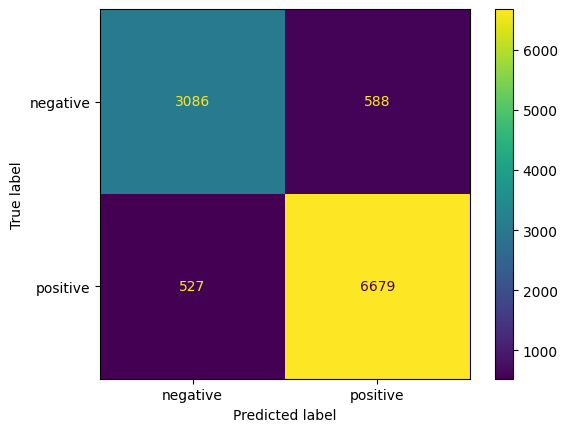

In [71]:
report(best_model)

Similar result and even slightly worse compare to logistic regression. Reasonable considering the mislabeled class and limitation.

In [72]:
df.head()

,text,score,date,app_version,target,target_binary,app_version_cut,text_processed,tokens,tokens_without_stopword,prediction,prediction_confidence
0,akun gopay saya di blok,1,2022-01-21 10:52:12,4.9.3,negative,0,4.9,akun gopay blok,"[akun, gopay, saya, di, blok]","[akun, gopay, blok]",negative,0.798842
2,Kenapa sih dari kemarin sy buka aplikasi gojek...,4,2021-11-29 22:58:12,4.9.3,positive,1,4.9,sih kemarin buka aplikasi gojek kasih bintang ...,"[kenapa, sih, dari, kemarin, saya, buka, aplik...","[sih, kemarin, buka, aplikasi, gojek, kasih, b...",negative,0.541668
3,Baru download gojek dan hape baru trus ditop u...,1,2022-09-03 15:21:17,4.9.3,negative,0,4.9,download gojek hape top lu gopay transaksi dia...,"[baru, download, gojek, dan, hape, baru, terus...","[download, gojek, hape, top, lu, gopay, transa...",positive,0.634071
4,Mantap,5,2022-01-15 10:05:27,4.9.3,positive,1,4.9,mantap,[mantap],[mantap],positive,0.995213
5,Bagus,4,2022-02-01 05:50:40,4.9.3,positive,1,4.9,bagus,[bagus],[bagus],positive,0.982354


In [73]:
df.to_csv('gojek_appreview_v47_49_preprocessed.csv')

# Deep Learning Model, taking into account word order and meaning with Embedding.

At this point, instead of continuing with deep learning models, we should get back to the data and re-label it instead for better performance. So on this points onward, purely for educational only.

In [74]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [75]:
# number of classes
K = df['target_binary'].max() + 1
K

2

In [76]:
df_train, df_test = train_test_split(df, test_size=0.33, random_state=42)

In [77]:
MAX_VOCAB_SIZE = 3000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train['tokens_without_stopword'])
sequences_train = tokenizer.texts_to_sequences(df_train['tokens_without_stopword'])
sequences_test = tokenizer.texts_to_sequences(df_test['tokens_without_stopword'])

In [78]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 11877 unique tokens.


In [79]:
# pad sequences to get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# sequence length
T = data_train.shape[1]

Shape of data train tensor: (22089, 55)


In [80]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (10880, 55)


# **RNN LSTM**

In [81]:
# number of classes
K = df['target_binary'].max() + 1
# Convert K to an integer if it's a float
K = int(K)

In [82]:
# embedding dimensionality
D = 10

# size of the embedding to (V + 1) x D, because the first index starts from 1 and not 0

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(16, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i, x)

In [83]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)

In [84]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 55)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 55, 10)              │         118,780 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 55, 16)              │           1,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 16)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,542 (470.87 KB)

 Trainable params: 120,542 (470.87 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
print('Training model...')
r = model.fit(
  data_train,
  df_train['target_binary'],
  epochs=5,
  validation_data=(data_test, df_test['target_binary'])
)

Training model...
Epoch 1/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.7358 - loss: 0.5298 - val_accuracy: 0.8985 - val_loss: 0.2717
Epoch 2/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.9049 - loss: 0.2548 - val_accuracy: 0.9093 - val_loss: 0.2377
Epoch 3/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.9197 - loss: 0.2217 - val_accuracy: 0.9105 - val_loss: 0.2335
Epoch 4/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9251 - loss: 0.2051 - val_accuracy: 0.9082 - val_loss: 0.2357
Epoch 5/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9281 - loss: 0.1956 - val_accuracy: 0.9093 - val_loss: 0.2359


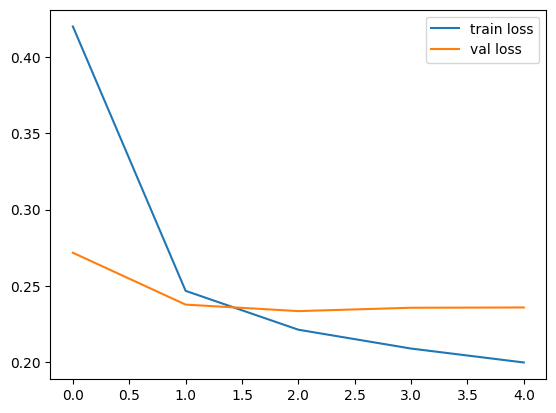

In [86]:
# plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

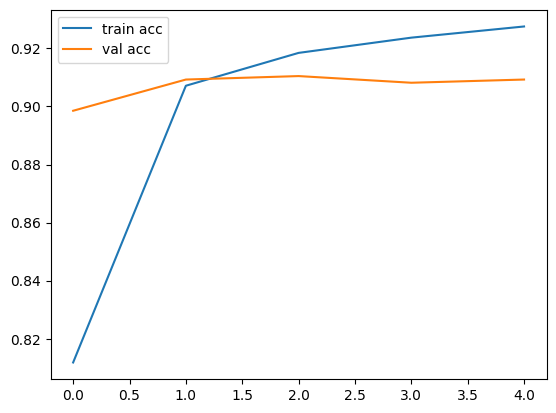

In [87]:
# plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

# **CNN**

In [88]:
D = 10

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(16, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i, x)

In [89]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 55)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 55, 10)              │         118,780 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 53, 16)              │             496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 16)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,310 (466.05 KB)

 Trainable params: 119,310 (466.05 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  df_train['target_binary'],
  epochs=5,
  validation_data=(data_test, df_test['target_binary'])
)

Training model...
Epoch 1/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7738 - loss: 0.4766 - val_accuracy: 0.9077 - val_loss: 0.2490
Epoch 2/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9113 - loss: 0.2336 - val_accuracy: 0.9050 - val_loss: 0.2382
Epoch 3/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9249 - loss: 0.2063 - val_accuracy: 0.9024 - val_loss: 0.2419
Epoch 4/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9314 - loss: 0.1889 - val_accuracy: 0.9074 - val_loss: 0.2430
Epoch 5/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9363 - loss: 0.1759 - val_accuracy: 0.9044 - val_loss: 0.2494


While a little uncommon, CNN models could be use to analyze text. The train time also much faster due to convolution (stride and/or pooling).

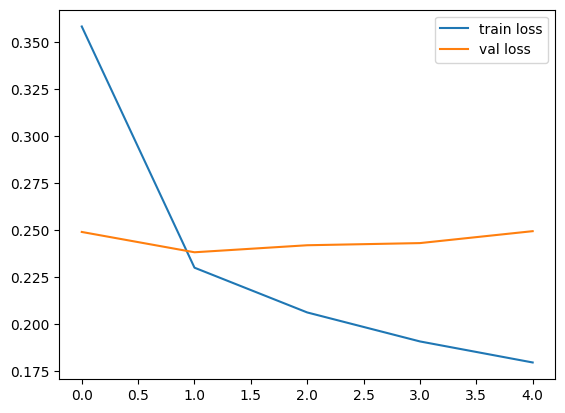

In [91]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

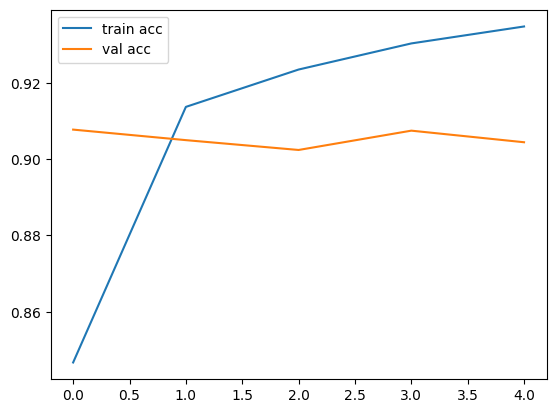

In [92]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

Both base model result indeed doesn't differ much from Logistic Regression model results. It could means that the data aren't complex enough that a simple Bag of Word methods could capture the sentiments. Beside that, the mislabeled data really need to be fix first.

# Gojek Sentiment BERT Fine Tuned NLP Model Prediction


In [93]:
!pip install accelerate
# requirement for using pytorch together with trainer

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3070, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2863, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 9

In [94]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

Exception ignored in: <function _xla_gc_callback at 0x7dabb4c66560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


In [95]:
!pip install transformers datasets

  Using cached huggingface_hub-0.27.0-py3-none-any.whl.metadata (13 kB)
Using cached huggingface_hub-0.27.0-py3-none-any.whl (450 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.23.4
    Uninstalling huggingface-hub-0.23.4:
      Successfully uninstalled huggingface-hub-0.23.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nlp-id 0.1.18.0 requires huggingface-hub==0.23.4, but you have huggingface-hub 0.27.0 which is incompatible.


In [96]:
df = pd.read_csv('/content/gojek_appreview_v47_49_preprocessed.csv')

In [97]:
df.head()

,Unnamed: 0,text,score,date,app_version,target,target_binary,app_version_cut,text_processed,tokens,tokens_without_stopword,prediction,prediction_confidence
0,0,akun gopay saya di blok,1,2022-01-21 10:52:12,4.9.3,negative,0,4.9,akun gopay blok,"['akun', 'gopay', 'saya', 'di', 'blok']","['akun', 'gopay', 'blok']",negative,0.798842
1,2,Kenapa sih dari kemarin sy buka aplikasi gojek...,4,2021-11-29 22:58:12,4.9.3,positive,1,4.9,sih kemarin buka aplikasi gojek kasih bintang ...,"['kenapa', 'sih', 'dari', 'kemarin', 'saya', '...","['sih', 'kemarin', 'buka', 'aplikasi', 'gojek'...",negative,0.541668
2,3,Baru download gojek dan hape baru trus ditop u...,1,2022-09-03 15:21:17,4.9.3,negative,0,4.9,download gojek hape top lu gopay transaksi dia...,"['baru', 'download', 'gojek', 'dan', 'hape', '...","['download', 'gojek', 'hape', 'top', 'lu', 'go...",positive,0.634071
3,4,Mantap,5,2022-01-15 10:05:27,4.9.3,positive,1,4.9,mantap,['mantap'],['mantap'],positive,0.995213
4,5,Bagus,4,2022-02-01 05:50:40,4.9.3,positive,1,4.9,bagus,['bagus'],['bagus'],positive,0.982354


In [98]:
df2 = df[['text', 'target_binary']]
df2.columns = ['sentence', 'label']
df2.to_csv('data.csv', index=None)

In [99]:
!head data.csv

sentence,label
akun gopay saya di blok,0
Kenapa sih dari kemarin sy buka aplikasi gojek malah keluar sendiri terus Saya kasih bintang 2 dulu kalo sudah normal sy kasih bintang 7,1
Baru download gojek dan hape baru trus ditop u gopay transaksi dialfamart transaksi bloked transaksilaporan di pusat bantuan gak jelas yang ditanyakan apa jawaban lainlama lama gojek dikelola Tokopedia udah nyimpangapa gojek anak bangsa seperti dulu apa punya Tokopedia,0
Mantap,1
Bagus,1
Coba dulu,0
Ok,1
Gimana ini kak pin saya salah terus padahal udah di ubah masih salah,0
Biar aman kamu tidak bisa pakai gojek Jadi saya uninstal biar aman,0


In [102]:
!pip install --upgrade huggingface_hub

In [104]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files='/content/data.csv')

ImportError: cannot import name 'EntryNotFoundError' from 'huggingface_hub.errors' (/usr/local/lib/python3.10/dist-packages/huggingface_hub/errors.py)

In [ ]:
raw_dataset

In [ ]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)

In [ ]:
split

In [ ]:
split['train'][1]

In [ ]:
from transformers import AutoTokenizer

In [ ]:
checkpoint = 'cahya/bert-base-indonesian-522M'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
tokenized_sentences = tokenizer(split['train'][1]['sentence'])
from pprint import pprint
pprint(tokenized_sentences)

In [ ]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=False)

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoConfig, Trainer, TrainingArguments

In [ ]:
config = AutoConfig.from_pretrained(checkpoint)
config

In [ ]:
config.id2label

In [ ]:
config.label2id

In [ ]:
target_map = {'positive': 1, 'negative': 0}
config.id2label = {v:k for k, v in target_map.items()}
config.label2id = target_map

In [ ]:
config.id2label

In [ ]:
config.label2id

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, config=config)

In [ ]:
pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model)

In [ ]:
training_args = TrainingArguments(
  output_dir='training_dir',
  evaluation_strategy='epoch',
  save_strategy='epoch',
  num_train_epochs=3,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=64,
)

In [ ]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}

In [ ]:
tokenized_datasets = split.map(tokenize_fn, batched=True)
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)



In [ ]:
trainer.train()

In [ ]:
!ls training_dir

In [ ]:
from transformers import pipeline

In [ ]:
savedmodel = pipeline('text-classification',
                      model='training_dir/checkpoint-2886',
                      device=0)

In [ ]:
s = split['test']['sentence'][1]
print(s)
savedmodel(s)

In [ ]:
# Meminta input manual dari pengguna
s = input("Masukkan kalimat untuk diprediksi: jelek banget pelayanannya")

# Menampilkan input untuk konfirmasi
print(f"Kalimat yang dimasukkan: {s}")

# Menggunakan model untuk memprediksi
hasil = savedmodel(s)

# Menampilkan hasil prediksi
print(hasil)


In [ ]:
!pip install flask-ngrok


In [ ]:
!pip install streamlit
